In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export 
from exp.nb_05b import *
torch.set_num_threads(2)

## Convolutional Neural Network

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
normalize??

In [6]:
x_train, x_valid = normalize_to(x_train, x_valid)

In [7]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

Quick check:

In [8]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [9]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [10]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [11]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

In [12]:
#export
def flatten(x):
    return x.view(x.shape[0], -1)

In [13]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

Simple CNN:

In [14]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [15]:
model = get_cnn_model(data)

In [16]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [17]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)

In [18]:
run = Runner(cb_funcs=cbfs)

In [19]:
%time run.fit(1, learn)

train: [2.0913625, tensor(0.2429)]
valid: [0.80126201171875, tensor(0.7452)]
CPU times: user 11.3 s, sys: 721 ms, total: 12 s
Wall time: 2.6 s


## CUDA
This takes too long on the CPU, time to use the GPU

In [20]:
#torch.version.cuda # was 10.0.130-0

In [21]:
# Flexible way
device = torch.device('cuda', 0)

In [22]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device
    def begin_fit(self):
        self.model.to(self.device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [23]:
# Less flexible but more convenient

In [24]:
torch.cuda.set_device(device)

In [25]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [26]:
cbfs.append(CudaCallback)

In [27]:
model = get_cnn_model(data)

In [28]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [29]:
%time run.fit(3, learn)

train: [2.12580640625, tensor(0.2660, device='cuda:0')]
valid: [1.3953279296875, tensor(0.4977, device='cuda:0')]
train: [0.62374703125, tensor(0.8004, device='cuda:0')]
valid: [0.2514187744140625, tensor(0.9279, device='cuda:0')]
train: [0.2091681640625, tensor(0.9372, device='cuda:0')]
valid: [0.15734266357421875, tensor(0.9524, device='cuda:0')]
CPU times: user 3.76 s, sys: 720 ms, total: 4.48 s
Wall time: 4.5 s


That's much faster!

## Refactor Model
Regroup all the conv/relu layers into a single function:

In [30]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Previous model can be used only for mnist because it has the 28x28 resizing hardcoded into it.

From now on let's do the mnist resizing in a batch transformation that can be implemented via a Callback so that the model is independant of the size:

In [31]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [32]:
(-1,)+(1, 28, 28)

(-1, 1, 28, 28)

In [33]:
mnist_view = view_tfm(1, 28, 28)

In [34]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [35]:
nfs = [8, 16, 32, 32]

In [36]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i + 1], 5 if i == 0 else 3)
        for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [37]:
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [38]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [39]:
model = get_cnn_model(data, nfs)

In [40]:
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [41]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [42]:
run.fit(3, learn)

train: [2.04477640625, tensor(0.2577, device='cuda:0')]
valid: [0.8242693359375, tensor(0.7562, device='cuda:0')]
train: [0.4540855859375, tensor(0.8593, device='cuda:0')]
valid: [0.211053125, tensor(0.9348, device='cuda:0')]
train: [0.190373984375, tensor(0.9427, device='cuda:0')]
valid: [0.138959130859375, tensor(0.9594, device='cuda:0')]


## Hooks
### Manual insertion
Intention: get telemetry about our model and track the mean and standard deviation of the activations in each layer. First, let's do it manually:

In [3]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [44]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [45]:
run.fit(2, learn)

train: [1.90839453125, tensor(0.3469, device='cuda:0')]
valid: [0.87156201171875, tensor(0.7196, device='cuda:0')]
train: [0.434145703125, tensor(0.8654, device='cuda:0')]
valid: [0.204466943359375, tensor(0.9390, device='cuda:0')]


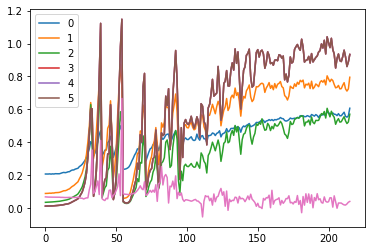

In [46]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

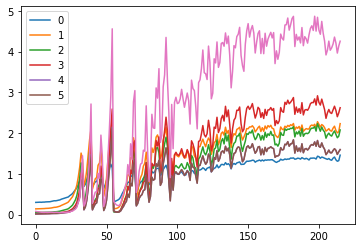

In [47]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

**This, truly, is not how we want this to look like! Ideally we want all means to be close to 0 and all stds to be close to 1 and not change over time. However, in the beginning of training, both, the means and the stds repeatedly increase exponentially to collapse back to ~0. This is due to poor initialization and has to be addressed!**

Let's look only at the first few iterations:

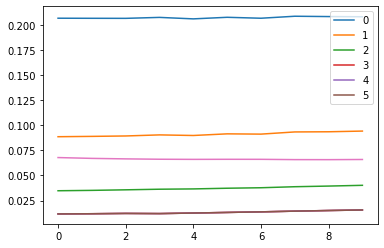

In [48]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

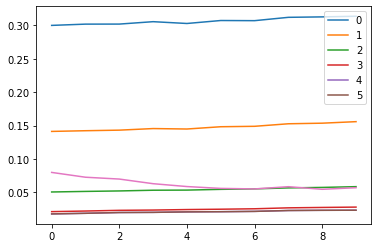

In [49]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

**This is really troubling as well, let's take a look at layer 5 for instance: the mean is close to 0, so far so good, but the std is close to 0 as well. This means that the activations vanished and there also is no gradient.**

### PyTorch hooks
Let's do the same thing but without creating a custom `Sequential` class:

In [68]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [69]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

`module.register_forward_hook` takes a function with the parameters `module`, `input`, `output` as input. Since we want a 4th parameter `i` we use a closure:

In [70]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [71]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))  # partial returns a func with 3 arguments as required

In [72]:
run.fit(1, learn)

train: [2.12004890625, tensor(0.2384, device='cuda:0')]
valid: [2.168899609375, tensor(0.1835, device='cuda:0')]


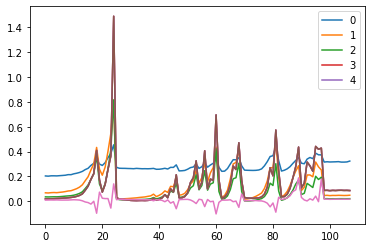

In [73]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

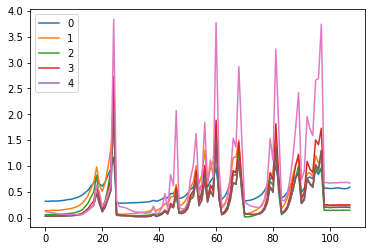

In [74]:
for o in act_stds: plt.plot(o)
plt.legend(range(5));

Same result here.

It is important to delete the hooks, otherwise memory is leaked. Let's make things easier and refactor this into a Hook class:

### Hook class

In [92]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [93]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [94]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [95]:
run.fit(1, learn)

train: [1.9985915625, tensor(0.3049, device='cuda:0')]
valid: [0.86028525390625, tensor(0.6890, device='cuda:0')]


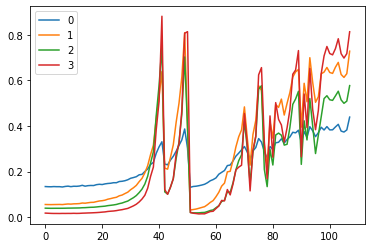

In [96]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### Hook*s* class
Until now we organized the hooks manually in a list. Let's build a class that does that for us!

Let's first create our own container that can store a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

1. single index
2. slice (like 1:5)
3. list of indices
4. mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like for x in ...

In [1]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
        
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # idx is supposed to be bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n {self.items[:10]}'
        if len(self)>10: res = res[:-1] + '...]'
        return res

In [151]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [152]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [153]:
t = ListContainer(range(10))

In [154]:
t[(1,2)], t[slice(1,3,1)], t[[False] * 7 + [True, False, True]]

([1, 2], [1, 2], [7, 9])

Let's use our custom `ListContainer` to build a class that organizes our single hooks:

In [393]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, modules, f):
        super().__init__([Hook(m, f) for m in modules])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()  # delete all hooks when we leave scope of context manager
    def __del__(self): self.remove()  # delete all hooks when 'Hooks' object goes out of scope
    
    def __delitem__(self, i):
        self[i].remove()  # remove method of Hook frees the device memory
        super().__delitem__(i)  # removes Hook from the list the ListContainer uses
    
    def remove(self):
        #while len(self) != 0: del(self[-1])
        for h in self: h.remove()

In [394]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [275]:
hooks = Hooks(model, append_stats)

In [276]:
hooks

Hooks (7 items)
 [<__main__.Hook object at 0x7fb7f8127048>, <__main__.Hook object at 0x7fb7f8127780>, <__main__.Hook object at 0x7fb7f8127358>, <__main__.Hook object at 0x7fb7f8127390>, <__main__.Hook object at 0x7fb7f8127cf8>, <__main__.Hook object at 0x7fb7e3e323c8>, <__main__.Hook object at 0x7fb7e3e32518>]

In [264]:
hooks.remove()

In [277]:
hooks

Hooks (7 items)
 [<__main__.Hook object at 0x7fb7f8127048>, <__main__.Hook object at 0x7fb7f8127780>, <__main__.Hook object at 0x7fb7f8127358>, <__main__.Hook object at 0x7fb7f8127390>, <__main__.Hook object at 0x7fb7f8127cf8>, <__main__.Hook object at 0x7fb7e3e323c8>, <__main__.Hook object at 0x7fb7e3e32518>]

In [278]:
hooks.remove()

In [279]:
hooks

Hooks (0 items)
 []

In [285]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x)#.cuda()

In [286]:
x.mean(), x.std()

(tensor(0.0063), tensor(1.0073))

So far so good!

In [287]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1691, grad_fn=<MeanBackward1>),
 tensor(0.2787, grad_fn=<StdBackward0>))

**So far so NOT GOOD!**

In [298]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)  # [0] accesses the convlayer in our case
        l[0].bias.data.zero_()

In [289]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.5060, grad_fn=<MeanBackward1>),
 tensor(0.8411, grad_fn=<StdBackward0>))

Much better!

train: [1.38899359375, tensor(0.5366, device='cuda:0')]
valid: [0.2692564453125, tensor(0.9104, device='cuda:0')]
train: [0.27363875, tensor(0.9178, device='cuda:0')]
valid: [0.15128546142578125, tensor(0.9516, device='cuda:0')]


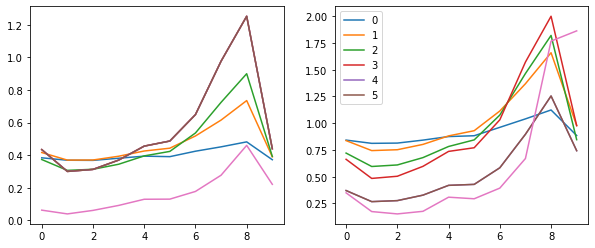

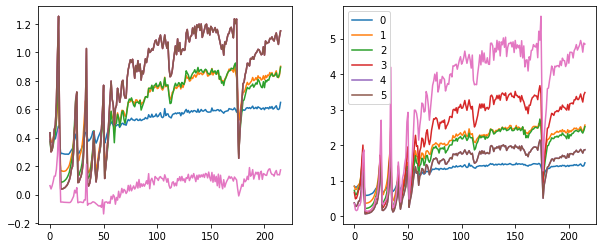

In [299]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

* **On the bright side:** the stds are not almost 0 anymore at the beginning of training.
* **On the not so bright side:** this repeated exponential explosion and collapsing of means and stds is still occuring.

### Other statistics
Until now we only tracked the means and standard deviations of the activations in each layer. Now, let's plot histograms of the activations:

In [417]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(bins=40, min=0, max=10))  # no GPU implementation

In [418]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [419]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [420]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.003443515625, tensor(0.6787, device='cuda:0')]
valid: [0.2667052978515625, tensor(0.9157, device='cuda:0')]


In [421]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

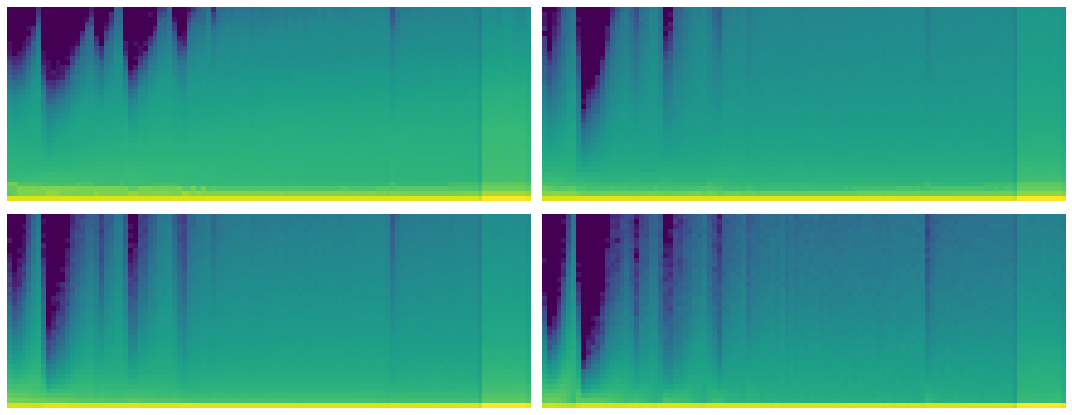

In [422]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

**This weird thing with the repeated explosion and collapse of mean and std is clearly visible. *The worst thing, however, is the yellow line! Most of our activations are around 0!!!***

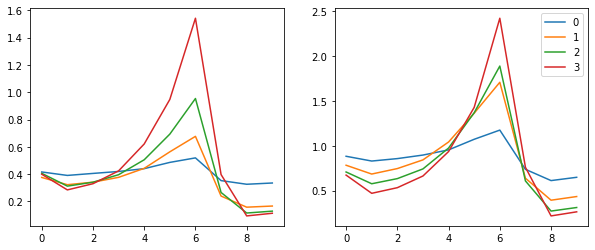

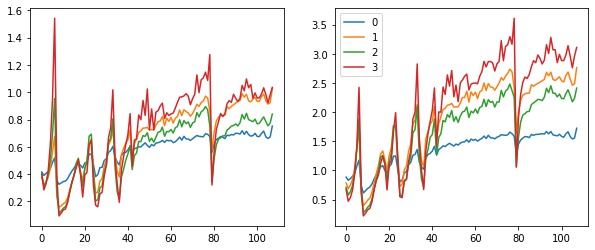

In [423]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for h in hooks[:4]:
    ms, ss, _ = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
plt.legend(range(4));

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for h in hooks[:4]:
    ms, ss, _ = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
plt.legend(range(4));

In [426]:
def get_perc_small_activations(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)  # count in lower two bins / count in all bins, per column

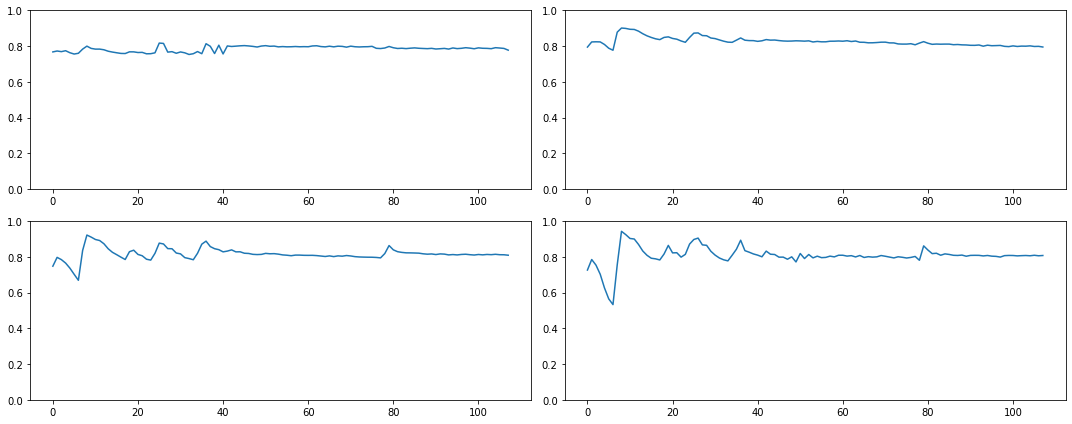

In [428]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_perc_small_activations(h))
    ax.set_ylim(0,1)
plt.tight_layout()

**Truly terrible news! In all considered layers the number of activations that fall in the smallest two bins is around 80%. These are basically wasted and not taking part in any useful computation. And you wouldn't even notice from looking at your loss and accuracy**

## Generalized ReLU
Let's train our model with a generalized ReLU that can be shifted and can have a maximum value.

In [440]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [
        layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)
    ]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)  # a is slope of rectifier
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [451]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(bins=40, min=-7, max=7))  # only line changed

In [599]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)

init_cnn(model,False)
learn, run =  get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5191366796875, tensor(0.8411, device='cuda:0')]
valid: [0.14957069091796876, tensor(0.9553, device='cuda:0')]


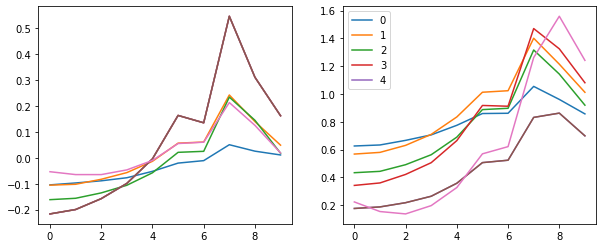

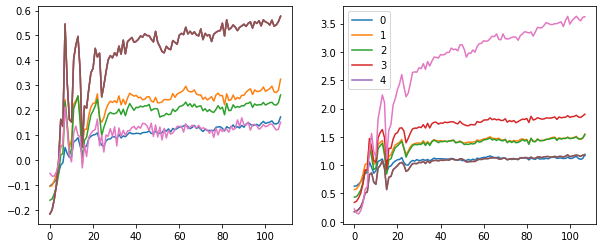

In [600]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

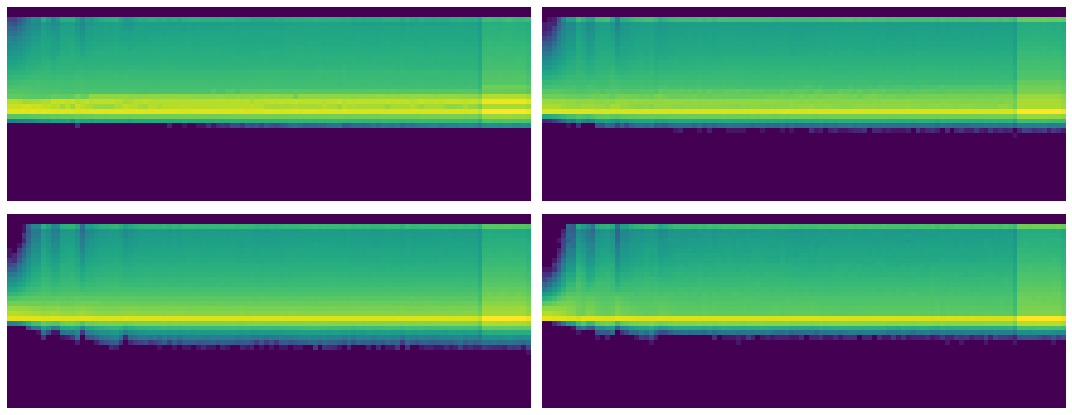

In [601]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

Vertical cut through histograms at a certain time:

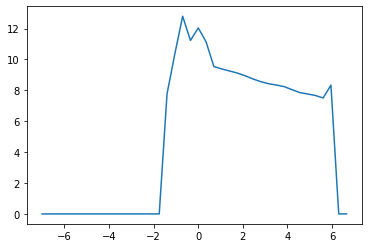

In [602]:
plt.plot(torch.arange(-7,7,14/40),get_hist(hooks[0])[:,20])

In [558]:
def get_perc_small_activations(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

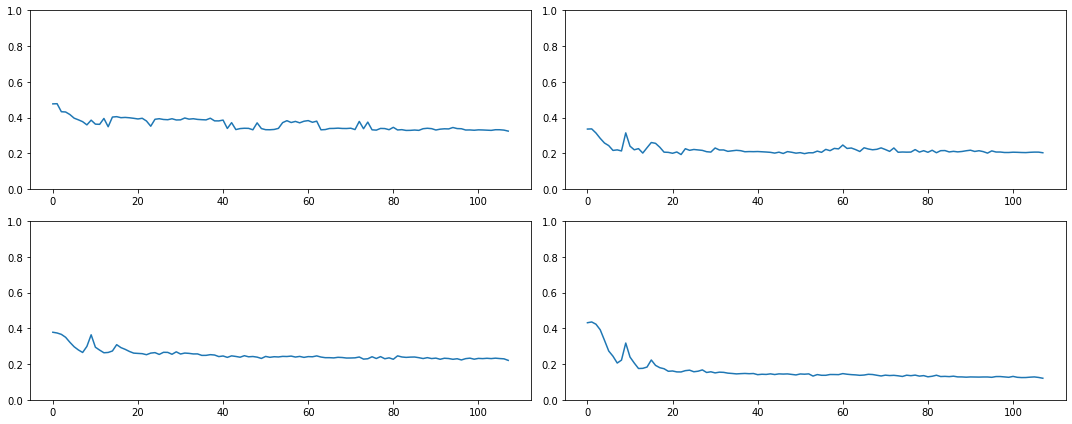

In [559]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_perc_small_activations(h))
    ax.set_ylim(0,1)
plt.tight_layout()

**Much, much better! Now fewer activations are waisted :D**

In [657]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [658]:
sched = combine_scheds([0.5,0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [659]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])
#leak=0.0, sub=0., maxv=1000.)  # lr change has no effect here because set by ParamScheduler

In [660]:
run.fit(8, learn)

train: [0.933558203125, tensor(0.7100, device='cuda:0')]
valid: [0.4894810546875, tensor(0.8334, device='cuda:0')]
train: [0.31025591796875, tensor(0.9062, device='cuda:0')]
valid: [0.165651513671875, tensor(0.9500, device='cuda:0')]
train: [0.23102857421875, tensor(0.9305, device='cuda:0')]
valid: [0.175589501953125, tensor(0.9460, device='cuda:0')]
train: [0.29172720703125, tensor(0.9132, device='cuda:0')]
valid: [0.10779591064453126, tensor(0.9678, device='cuda:0')]
train: [0.113008037109375, tensor(0.9659, device='cuda:0')]
valid: [0.09370181884765626, tensor(0.9734, device='cuda:0')]
train: [0.068554521484375, tensor(0.9781, device='cuda:0')]
valid: [0.0782000244140625, tensor(0.9781, device='cuda:0')]
train: [0.0504827734375, tensor(0.9845, device='cuda:0')]
valid: [0.07403236694335938, tensor(0.9790, device='cuda:0')]
train: [0.042667431640625, tensor(0.9873, device='cuda:0')]
valid: [0.07167621459960938, tensor(0.9802, device='cuda:0')]


In [662]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [663]:
run.fit(8, learn)

train: [1.1761003125, tensor(0.6361, device='cuda:0')]
valid: [0.2860722412109375, tensor(0.9152, device='cuda:0')]
train: [0.29630751953125, tensor(0.9088, device='cuda:0')]
valid: [0.14907406005859375, tensor(0.9553, device='cuda:0')]
train: [0.26630265625, tensor(0.9202, device='cuda:0')]
valid: [0.7643763671875, tensor(0.7747, device='cuda:0')]
train: [0.142552919921875, tensor(0.9578, device='cuda:0')]
valid: [0.08288306884765625, tensor(0.9758, device='cuda:0')]
train: [0.0774767822265625, tensor(0.9764, device='cuda:0')]
valid: [0.08538939819335938, tensor(0.9753, device='cuda:0')]
train: [0.05475548828125, tensor(0.9829, device='cuda:0')]
valid: [0.06435366821289062, tensor(0.9819, device='cuda:0')]
train: [0.03924431884765625, tensor(0.9882, device='cuda:0')]
valid: [0.0626000732421875, tensor(0.9827, device='cuda:0')]
train: [0.03291907958984375, tensor(0.9904, device='cuda:0')]
valid: [0.05991870727539062, tensor(0.9834, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0). Uniform init and normal init appear to give similar results in the end. Should be tested more thoroughly though.

## Export

In [4]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to exp/nb_06.py
